# CIFAR-10 Image Classification Using a Convolutional Neural Network

In [1]:
import collections
import math
import typing

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

## Step 1: Load and Preprocess Image Data

This data preprocessing pipeline will convert images from PIL image objects to PyTorch tensors, then normalize each of the RGB channels to have a mean and standard deviation of $0.5$.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
batch_size = 4

Here we load the training and testing datasets.

In [4]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

We can use this function to show some of the images.

In [7]:
def imshow(img: Tensor) -> None:
    # Un-normalize the image
    img = img / 2 + 0.5

    # Convert image to numpy array
    npimg = img.numpy()

    # Show the transposed image (we have to transpose because in the data
    # pipeline the `ToTensor` function changed the shape of the images
    # from (H x W x C) to (C x H x W))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [8]:
image_iterator = iter(train_loader)
images, labels = next(image_iterator)

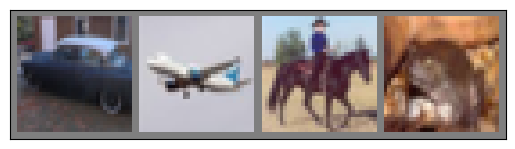

In [9]:
imshow(torchvision.utils.make_grid(images))

In [10]:
print(list(classes[labels[j]] for j in range(batch_size)))

['car', 'plane', 'horse', 'frog']


As an improvement of the `imshow` function above, this function also outputs the label names above the images.

In [11]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
def show_images(images: Tensor, class_names: typing.List[str], actual_labels: Tensor, predicted_labels: typing.Optional[Tensor] = None) -> None:
    number_of_images = images.shape[0]

    fig: Figure
    axes: typing.List[Axes]

    fig, axes = plt.subplots(1, number_of_images, figsize=(8, 2))

    for i in range(number_of_images):
        img = images[i] / 2 + 0.5          # Un-normalize
        npimg = img.numpy()                # Tensor -> NumPy
        npimg = npimg.transpose((1, 2, 0)) # CxHxW -> HxWxC

        if predicted_labels is None:
            axes[i].set_title(class_names[actual_labels[i]])
        else:
            label_text = TextArea('Label: ')
            actual_label = TextArea(class_names[actual_labels[i]], textprops=dict(color='blue'))
            prediction_text = TextArea('Prediction: ')
            prediction_label = TextArea(class_names[predicted_labels[i]], textprops=dict(color='red'))
            hbox_actual = HPacker(children=[label_text, actual_label], align='center', pad=0, sep=0)
            hbox_prediction = HPacker(children=[prediction_text, prediction_label], align='center', pad=0, sep=0)
            vbox = VPacker(children=[hbox_actual, hbox_prediction], align='right', pad=0, sep=0)
            anchor = AnchoredOffsetbox(loc='upper center', child=vbox, pad=0.1, frameon=False, bbox_to_anchor=(0.5, 1.25), bbox_transform=axes[i].transAxes, borderpad=0)
            axes[i].add_artist(anchor)

        axes[i].imshow(npimg)
        axes[i].axis('off')

    fig.suptitle('Batch of Images')
    plt.tight_layout()
    plt.show()

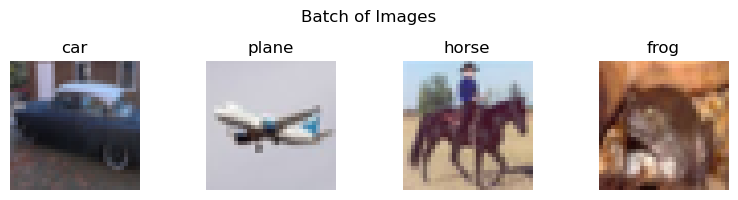

In [12]:
show_images(images, classes, labels)

## Step 2: Define the Convolutional Neural Network

This CNN design was copied from the [PyTorch CNN tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). It describes a basic CNN with two convolution layers and three fully-connected layers.

In [13]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten(1)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flat(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)

        return x

In [14]:
cnn = CNN()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

## Step 3: Train the Network

In [16]:
@torch.no_grad()
def estimate_loss(
    model: CNN,
    data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    eval_iterations: typing.Optional[int] = None,
    device: typing.Optional[torch.device] = None
) -> torch.types.Number:
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        if eval_iterations is not None:
            if i == eval_iterations:
                break
        if device is not None:
            images = images.to(device)
            labels = labels.to(device)
        outputs = model(images)
        loss: Tensor = criterion(outputs, labels)
        losses.append(loss.item())
    return torch.tensor(losses).mean().item()

In [17]:
epochs = 2
losses = torch.zeros(epochs * len(train_loader))

for epoch in range(epochs):

    cnn.train()

    for i, (images, labels) in enumerate(train_loader, 0):

        optimizer.zero_grad()

        outputs = cnn(images)

        loss: Tensor = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        losses[epoch * i + i] = loss.item()

    cnn.eval()

    estimated_training_loss = estimate_loss(cnn, train_loader, criterion, 250)
    estimated_testing_loss = estimate_loss(cnn, test_loader, criterion, 250)

    print(f'{epoch=}, {estimated_training_loss=:.4f}, {estimated_testing_loss=:.4f}')

epoch=0, estimated_training_loss=1.3615, estimated_testing_loss=1.4067
epoch=1, estimated_training_loss=1.2489, estimated_testing_loss=1.2390


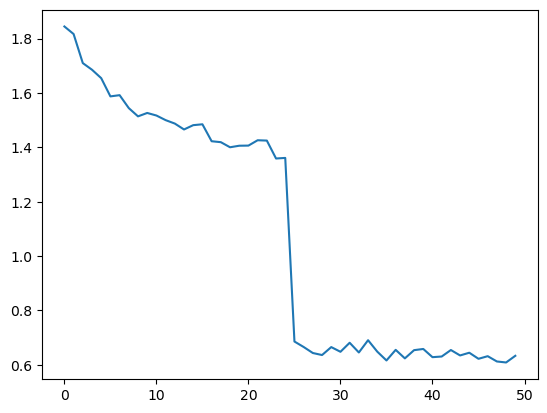

In [18]:
plt.figure()
plt.plot(losses.view(-1, 500).mean(dim=1))
plt.show()

## Step 4: Test the Network

In [19]:
test_image_iterator = iter(test_loader)

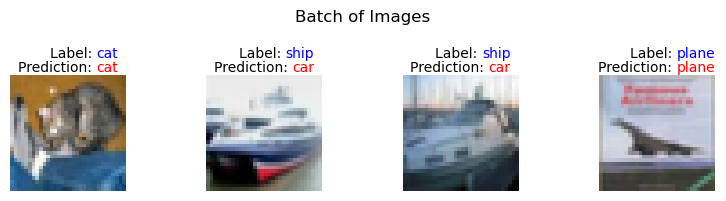

In [20]:
images, labels = next(test_image_iterator)
output = cnn(images)
_, predicted = torch.max(output, 1)
show_images(images, classes, labels, predicted)

In [21]:
cnn.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn(images)
        _, predicted_labels = torch.max(outputs, 1)
        total += labels.shape[0]
        correct += (predicted_labels == labels).sum().item()
print(f'Out of {total} test images the CNN labeled {correct} correctly ({(correct / total)*100:.2f}%)')

Out of 10000 test images the CNN labeled 5480 correctly (54.80%)


In [22]:
cnn.eval()
total = {class_name: 0 for class_name in classes}
correct = {class_name: 0 for class_name in classes}

with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn(images)
        _, predicted_labels = torch.max(outputs, 1)
        for actual_label, predicted_label in zip(labels, predicted_labels):
            if actual_label == predicted_label:
                correct[classes[predicted_label]] += 1
            total[classes[actual_label]] += 1

for class_name in sorted(classes):
    print(f'{class_name + ":":6s} {correct[class_name]:<3d} correct out of {total[class_name]:<4d} total ({(correct[class_name] / total[class_name])*100:.2f}%)')

bird:  345 correct out of 1000 total (34.50%)
car:   868 correct out of 1000 total (86.80%)
cat:   258 correct out of 1000 total (25.80%)
deer:  417 correct out of 1000 total (41.70%)
dog:   490 correct out of 1000 total (49.00%)
frog:  736 correct out of 1000 total (73.60%)
horse: 674 correct out of 1000 total (67.40%)
plane: 515 correct out of 1000 total (51.50%)
ship:  624 correct out of 1000 total (62.40%)
truck: 553 correct out of 1000 total (55.30%)


## Step 5: Kick it into High Gear

I'm going to use some optimization techniques to outperform the PyTorch documentation's CNN guide.

First, we're going to use CUDA if it's available to speed things up.

In [23]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "N/A")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

Torch version: 2.5.1
CUDA available: True
CUDA version: 12.4
Current device: 0
Device name: NVIDIA GeForce RTX 3060


In [24]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CUDA


In [25]:
H = 32 # Image height
W = 32 # Image width

layers: typing.OrderedDict[str, nn.Module] = collections.OrderedDict([
    ('conv_1_1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same')),  # in: (3, H, W) -> out: (16, H, W)
    ('conv_1_relu_1', nn.ReLU()),                                                            # in: (16, H, W) -> out: (16, H, W)
    ('conv_1_norm', nn.BatchNorm2d(num_features=16)),                                        # in: (16, H, W) -> out: (16, H, W)
    ('conv_1_2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')), # in: (16, H, W) -> out: (32, H, W)
    ('conv_1_relu_2', nn.ReLU()),                                                            # in: (32, H, W) -> out: (32, H, W)
    ('pool_1', nn.MaxPool2d(kernel_size=2, stride=2)),                                       # in: (32, H, W) -> out: (32, H/2, W/2)

    ('conv_2_1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')),  # in: (32, H/2, W/2) -> out: (64, H/2, W/2)
    ('conv_2_relu_1', nn.ReLU()),                                                             # in: (64, H/2, W/2) -> out: (64, H/2, W/2)
    ('conv_2_norm', nn.BatchNorm2d(num_features=64)),                                         # in: (64, H/2, W/2) -> out: (64, H/2, W/2)
    ('conv_2_2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')), # in: (64, H/2, W/2) -> out: (128, H/2, W/2)
    ('conv_2_relu_2', nn.ReLU()),                                                             # in: (128, H/2, W/2) -> out: (128, H/2, W/2)
    ('pool_2', nn.MaxPool2d(kernel_size=2, stride=2)),                                        # in: (128, H/2, W/2) -> out: (128, H/4, W/4)

    ('flat', nn.Flatten(start_dim=1)), # in: (128, H/4, W/4) -> out: (124 * H/4 * W/4)

    ('fc1', nn.Linear(in_features=128 * H//4 * W//4, out_features=64)), # in: (128 * H/8 * W/8) -> out: (64)
    ('fcrelu1', nn.ReLU()),                                             # in: (64) -> out: (64)
    ('drop', nn.Dropout(0.75)),                                         # in: (64) -> out: (64)

    ('fc3', nn.Linear(in_features=64, out_features=10)) # in: (64) -> out: (10)
])

In [26]:
cnn = nn.Sequential(layers)

cnn = cnn.to(device)

# with torch.no_grad():
#     cnn.fc3.weight *= 0.01

for p in cnn.parameters():
    p.requires_grad = True

print(f'Number of parameters: {sum(p.nelement() for p in cnn.parameters())}')

Number of parameters: 622602


In [27]:
batch_size = 128
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

In [29]:
epochs = 15
losses = []
estimated_training_losses = []
estimated_testing_losses = []

ud_detail = []

train_iter = iter(train_loader)

for epoch in range(epochs):
    cnn.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(images)
        loss: Tensor = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            param_updates = []
            for name, p in cnn.named_parameters():
                if p.grad is not None:
                    update_ratio = (scheduler.get_last_lr()[0] * p.grad).std() / (p.data.std() + 1e-8)
                    param_updates.append((name, update_ratio.log10().item()))
            ud_detail.append(param_updates)

        losses.append(loss.item())

    cnn.eval()
    estimated_training_loss = estimate_loss(cnn, train_loader, criterion, None, device=device)
    estimated_testing_loss = estimate_loss(cnn, test_loader, criterion, None, device=device)
    estimated_training_losses.append(estimated_training_loss)
    estimated_testing_losses.append(estimated_testing_loss)
    learning_rate = scheduler.get_last_lr()[0]
    print(f'{epoch=}, {estimated_training_loss=:.4f}, {estimated_testing_loss=:.4f}, {learning_rate=:.8f}')
    scheduler.step()

epoch=0, estimated_training_loss=1.6721, estimated_testing_loss=1.6725, learning_rate=0.01000000
epoch=1, estimated_training_loss=1.4996, estimated_testing_loss=1.5076, learning_rate=0.01000000
epoch=2, estimated_training_loss=1.3326, estimated_testing_loss=1.3522, learning_rate=0.01000000
epoch=3, estimated_training_loss=1.1780, estimated_testing_loss=1.2141, learning_rate=0.01000000
epoch=4, estimated_training_loss=0.9918, estimated_testing_loss=1.0460, learning_rate=0.01000000
epoch=5, estimated_training_loss=0.9276, estimated_testing_loss=0.9979, learning_rate=0.00950000
epoch=6, estimated_training_loss=0.9617, estimated_testing_loss=1.0470, learning_rate=0.00950000
epoch=7, estimated_training_loss=0.7885, estimated_testing_loss=0.8825, learning_rate=0.00950000
epoch=8, estimated_training_loss=0.7217, estimated_testing_loss=0.8296, learning_rate=0.00950000
epoch=9, estimated_training_loss=0.7093, estimated_testing_loss=0.8492, learning_rate=0.00950000
epoch=10, estimated_training_l

<Figure size 640x480 with 0 Axes>

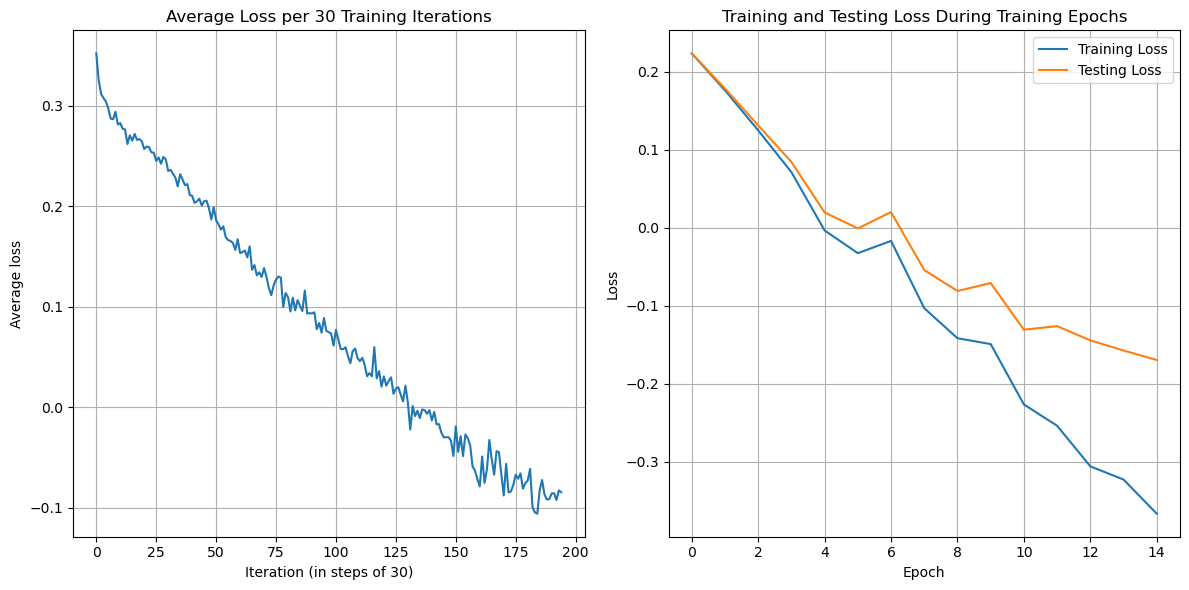

In [30]:
plt.figure()
fig: Figure
axs: typing.List[Axes]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
avg_window_size = 30
# axs[0].plot(losses.view(-1, 170).mean(dim=1))
axs[0].plot(torch.tensor(losses).unfold(0, avg_window_size, avg_window_size).log10().mean(dim=1))
axs[0].set_title(f'Average Loss per {avg_window_size} Training Iterations')
axs[0].set_xlabel(f'Iteration (in steps of {avg_window_size})')
axs[0].set_ylabel('Average loss')
axs[0].grid()
axs[1].plot(torch.tensor(estimated_training_losses).log10(), label='Training Loss')
axs[1].plot(torch.tensor(estimated_testing_losses).log10(), label='Testing Loss')
axs[1].set_title('Training and Testing Loss During Training Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid()
plt.legend()
plt.tight_layout()
plt.show()

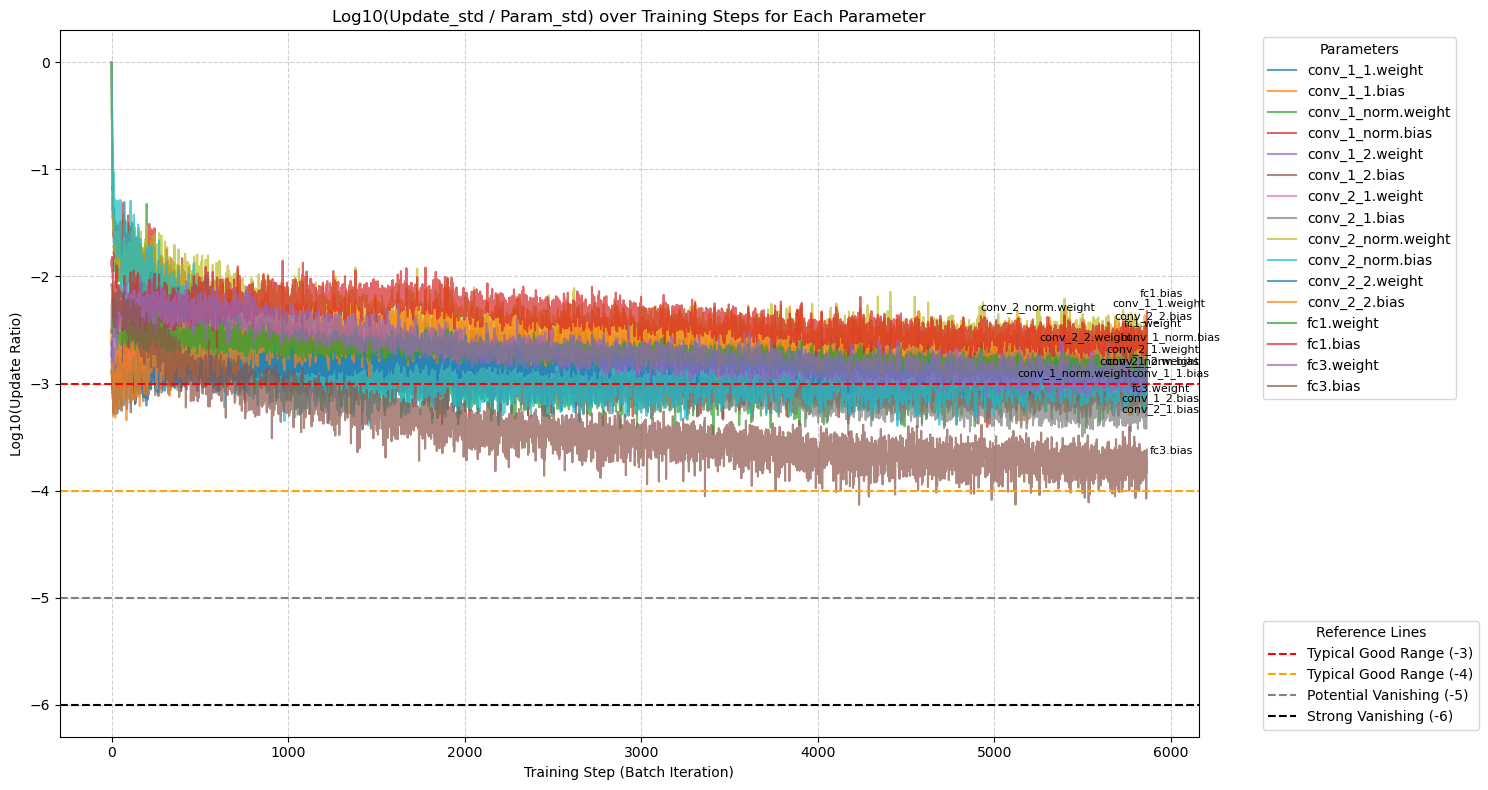

In [31]:
from adjustText import adjust_text
all_param_names = []
for step_data in ud_detail:
    for name, _ in step_data:
        if name not in all_param_names:
            all_param_names.append(name)
param_ud_trends = {name: [] for name in all_param_names}
param_ud_steps = {name: [] for name in all_param_names}
for step_index, step_data in enumerate(ud_detail):
    current_step_param_values = {name: value for name, value in step_data}
    for name in all_param_names:
        if name in current_step_param_values:
            param_ud_trends[name].append(current_step_param_values[name])
            param_ud_steps[name].append(step_index)

plt.figure(figsize=(15, 8))
plt.title('Log10(Update_std / Param_std) over Training Steps for Each Parameter')
plt.xlabel('Training Step (Batch Iteration)')
plt.ylabel('Log10(Update Ratio)')

param_handles = []
param_labels = []
texts = []

for name in all_param_names:
    valid_steps = param_ud_steps[name]
    valid_trends = param_ud_trends[name]
    if len(valid_trends) > 0:
        line, = plt.plot(valid_steps, valid_trends, label=name, alpha=0.7)
        param_labels.append(name)
        param_handles.append(line)
        # texts.append(plt.text(valid_steps[len(valid_steps)//2] + 5, valid_trends[len(valid_trends)//2], name, fontsize=8, va='center'))
        texts.append(plt.text(valid_steps[-1] + 5, valid_trends[-1], name, fontsize=8, va='center'))
        # plt.annotate(name, xy=(valid_steps[0], valid_trends[0]), xytext=(5, 0), textcoords='offset points', fontsize=8, va='center', arrowprops=dict(arrowstyle='-'))

adjust_text(texts)#, arrowprops=dict(arrowstyle='->', color='gray'))
legend1 = plt.legend(handles=param_handles, labels=param_labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Parameters")
plt.gca().add_artist(legend1)  # Needed to retain first legend

ref1 = plt.axhline(y=-3, color='r', linestyle='--', label='Typical Good Range (-3)')
ref2 = plt.axhline(y=-4, color='orange', linestyle='--', label='Typical Good Range (-4)')
ref3 = plt.axhline(y=-5, color='gray', linestyle='--', label='Potential Vanishing (-5)')
ref4 = plt.axhline(y=-6, color='black', linestyle='--', label='Strong Vanishing (-6)') # Your observed value

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.legend(handles=[ref1, ref2, ref3, ref4], loc='lower left', bbox_to_anchor=(1.05, 0), title="Reference Lines")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

/tmp/ipykernel_105026/2416222985.py:61: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


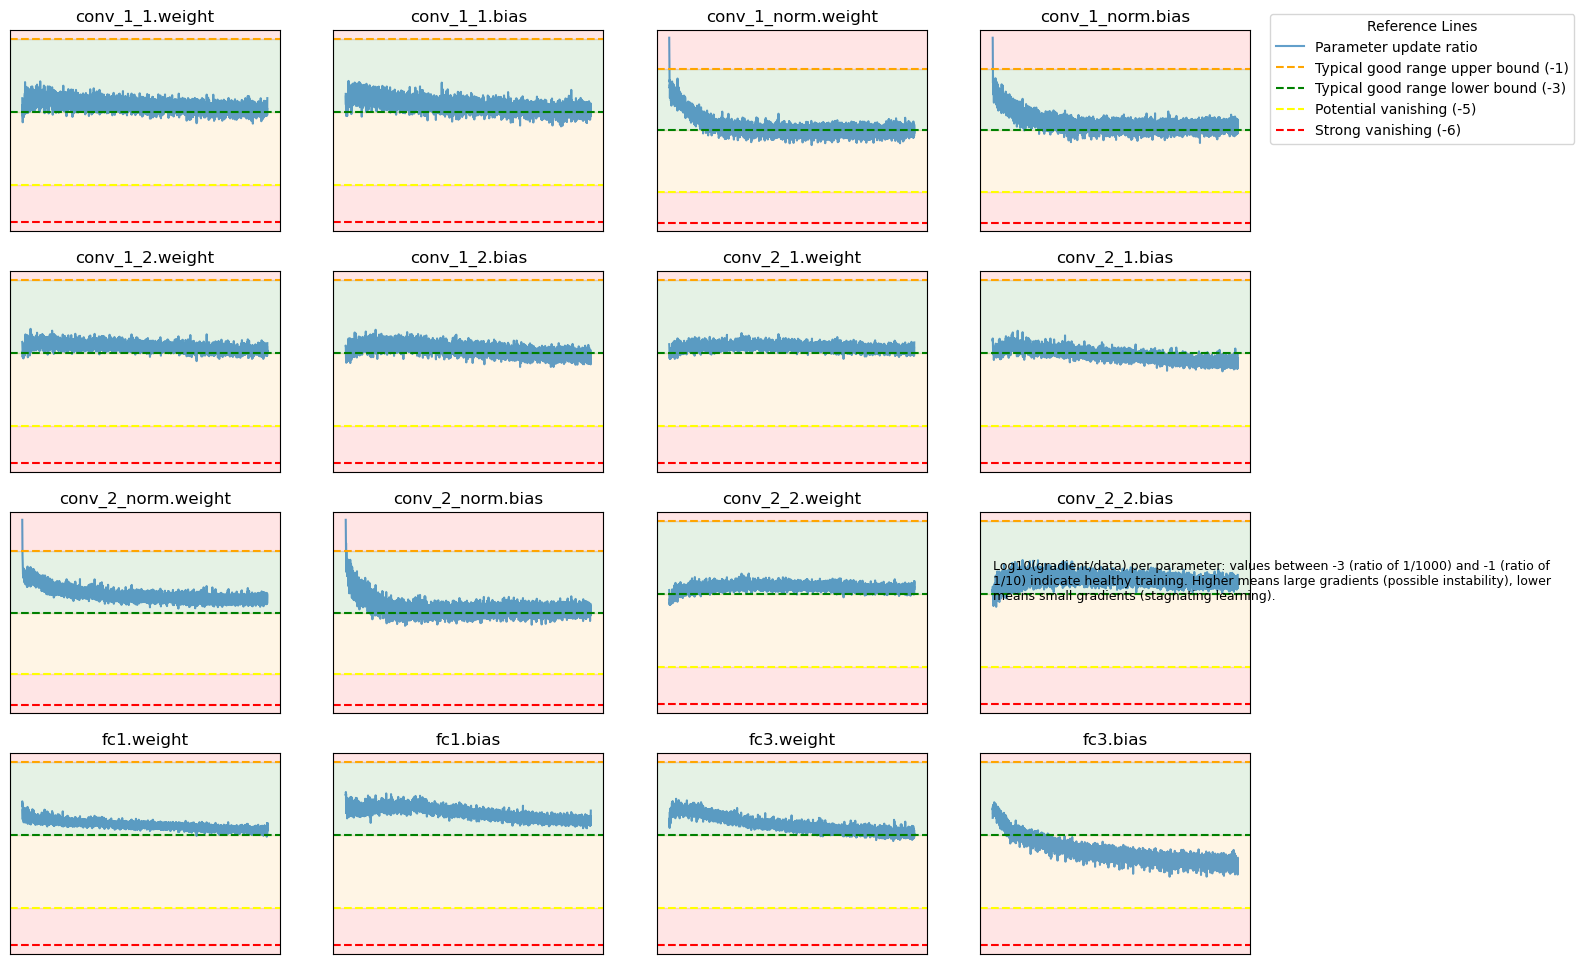

In [32]:
all_param_names = []
for step_data in ud_detail:
    for name, _ in step_data:
        if name not in all_param_names:
            all_param_names.append(name)
param_ud_trends = {name: [] for name in all_param_names}
param_ud_steps = {name: [] for name in all_param_names}
for step_index, step_data in enumerate(ud_detail):
    current_step_param_values = {name: value for name, value in step_data}
    for name in all_param_names:
        if name in current_step_param_values:
            param_ud_trends[name].append(current_step_param_values[name])
            param_ud_steps[name].append(step_index)

number_of_plots = 0
for name in all_param_names:
    valid_steps = param_ud_steps[name]
    valid_trends = param_ud_trends[name]
    if len(valid_trends) > 0:
        number_of_plots += 1

cols = math.ceil(math.sqrt(number_of_plots))
rows = math.ceil(number_of_plots / cols)
fig: Figure
axs: typing.List[Axes]
fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axs = axs.flatten()

param_handles = []
param_labels = []
texts = []
from matplotlib.patches import Rectangle
for i, name in enumerate(all_param_names):
    valid_steps = param_ud_steps[name]
    valid_trends = param_ud_trends[name]
    if len(valid_trends) > 0:
        line, = axs[i].plot(valid_steps, valid_trends, label='Parameter update ratio', alpha=0.7)
        axs[i].set_ylim((min(min(valid_trends), -6) - 0.25, max(max(valid_trends), -1) + 0.25))
        axs[i].axhspan(axs[i].get_ylim()[1], -1, color='red', alpha=0.1)
        axs[i].axhspan(-1, -3, color='green', alpha=0.1)
        axs[i].axhspan(-3, -5, color='orange', alpha=0.1)
        axs[i].axhspan(-5, axs[i].get_ylim()[0], color='red', alpha=0.1)
        ref1 = axs[i].axhline(y=-1, color='orange', linestyle='--', label='Typical good range upper bound (-1)')
        ref2 = axs[i].axhline(y=-3, color='green', linestyle='--', label='Typical good range lower bound (-3)')
        ref3 = axs[i].axhline(y=-5, color='yellow', linestyle='--', label='Potential vanishing (-5)')
        ref4 = axs[i].axhline(y=-6, color='red', linestyle='--', label='Strong vanishing (-6)')
        axs[i].grid()
        axs[i].set_title(f'{name}')
        axs[i].set_xticks([])
        axs[i].set_yticks([])

plt.legend(handles=[line, ref1, ref2, ref3, ref4], loc='lower left', bbox_to_anchor=(1.05, rows), title='Reference Lines')
plt.text(
    1.25,
    rows-0.5,
    'Log10(gradient/data) per parameter: values between -3 (ratio of 1/1000) and -1 (ratio of 1/10) indicate healthy training. Higher means large gradients (possible instability), lower means small gradients (stagnating learning).',
    ha='left',
    fontsize=9,
    wrap=True
)
plt.tight_layout()
plt.show()

In [33]:
def tensor2img(t):
    a = images[0] / 2 + 0.5          # Un-normalize
    b = a.cpu().numpy()                # Tensor -> NumPy
    return b.transpose((1, 2, 0)) # CxHxW -> HxWxC

In [34]:
activations = dict()
gradients = dict()
def get_activation(name: str) -> typing.Callable[[nn.Module, typing.Tuple[torch.Tensor, ...], typing.Union[torch.Tensor, typing.Tuple[torch.Tensor, ...]]], None]:
    def hook(model: nn.Module, input_tensor: typing.Tuple[Tensor, ...], output_tensor: Tensor | typing.Tuple[Tensor]):
        global activations
        activations[name] = output_tensor.detach()
    return hook
def get_gradient(name: str) -> typing.Callable[[nn.Module, typing.Tuple[torch.Tensor, ...], typing.Union[torch.Tensor, typing.Tuple[torch.Tensor, ...]]], None]:
    def hook(model: nn.Module, grad_input: typing.Tuple[Tensor, ...], grad_output: Tensor | typing.Tuple[Tensor]):
        global gradients
        gradients[name] = grad_output[0].detach()
    return hook
for name, layer in cnn.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(get_activation(name))
        layer.register_full_backward_hook(get_gradient(name))
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)
outputs = cnn(images)
_, predicted = torch.max(output, 1)

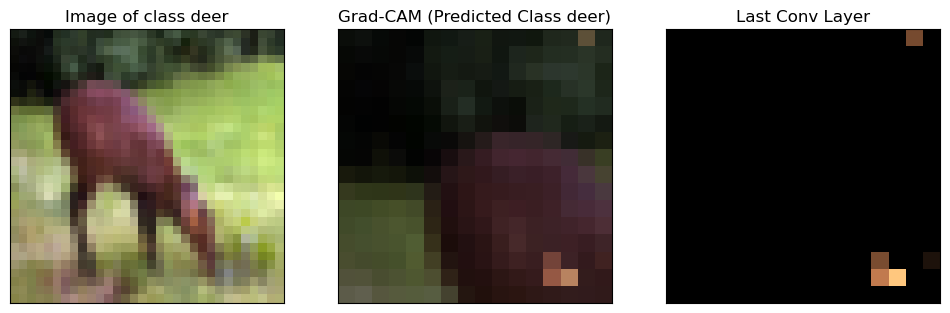

In [170]:
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)
image = images[0].unsqueeze(0)
label = labels[0].unsqueeze(0)
cnn.eval()
cnn.zero_grad()
output = cnn(image)
_, predicted = torch.max(output, 1)
output[0, predicted].backward()
# loss: Tensor = criterion(outputs, labels)
# loss.backward()
grad = gradients['conv_2_2']
act = activations['conv_2_2']

# Compute Grad-CAM: weighted sum over channels
weights = grad.mean(dim=(2, 3), keepdim=True)  # global avg pool over H and W
cam = (weights * act).sum(dim=1)               # [1, H, W]
cam = F.relu(cam)                              # clamp negative values

# Normalize to [0, 1]
cam -= cam.min()
cam /= cam.max()
cam = cam.squeeze().cpu().numpy()

# Convert input tensor to NumPy for plotting
img_np = images[0].squeeze().permute(1, 2, 0).cpu().numpy()
img_np -= img_np.min()
img_np /= img_np.max()

# Resize cam to image size if needed
# from scipy.ndimage import zoom
# cam_resized = zoom(cam, (img_np.shape[0] / cam.shape[0], img_np.shape[1] / cam.shape[1]))

# Plot overlay
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(img_np)
axs[0].set_title(f'Image of class {classes[label]}')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(img_np)
axs[1].imshow(cam, cmap='copper', alpha=0.5)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title(f"Grad-CAM (Predicted Class {classes[predicted]})")
axs[2].imshow(cam, cmap='copper')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title(f"Last Conv Layer")
plt.show()

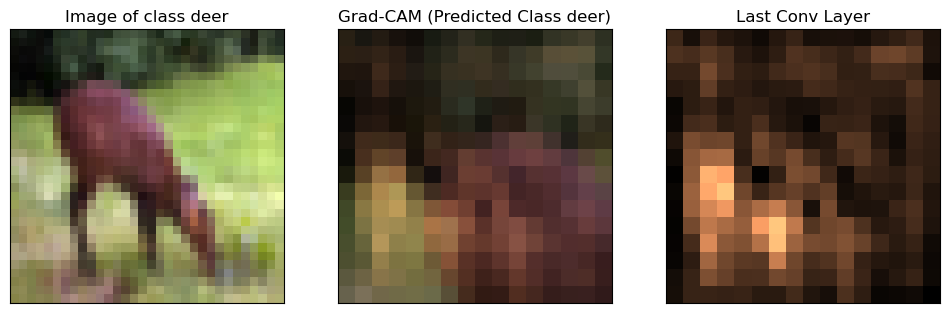

In [171]:
def gradcam_plus_plus(act: torch.Tensor, grad: torch.Tensor) -> np.ndarray:
    """
    act: activation from conv layer, shape [1, C, H, W]
    grad: gradient w.r.t. activations, shape [1, C, H, W]
    Returns: heatmap as np.ndarray of shape [H, W]
    """
    grad = grad[0]  # [C, H, W]
    act = act[0]    # [C, H, W]

    # Compute second-order and third-order gradients
    grad2 = grad ** 2
    grad3 = grad2 * grad

    # Sum over spatial dimensions
    sum_act = act.sum(dim=(1, 2), keepdim=True)  # [C, 1, 1]
    eps = 1e-8

    alpha = grad2 / (2 * grad2 + sum_act * grad3 + eps)  # [C, H, W]
    relu_grad = F.relu(grad)

    weights = (alpha * relu_grad).sum(dim=(1, 2))  # [C]
    cam = (weights[:, None, None] * act).sum(dim=0)  # [H, W]

    cam = F.relu(cam)
    cam -= cam.min()
    cam /= cam.max() + eps
    return cam.cpu().numpy()

# output[0, pred_class].backward()
cam = gradcam_plus_plus(activations['conv_2_2'], gradients['conv_2_2'])

fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(img_np)
axs[0].set_title(f'Image of class {classes[label]}')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(img_np)
axs[1].imshow(cam, cmap='copper', alpha=0.5)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title(f"Grad-CAM (Predicted Class {classes[predicted]})")
axs[2].imshow(cam, cmap='copper')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title(f"Last Conv Layer")
plt.show()


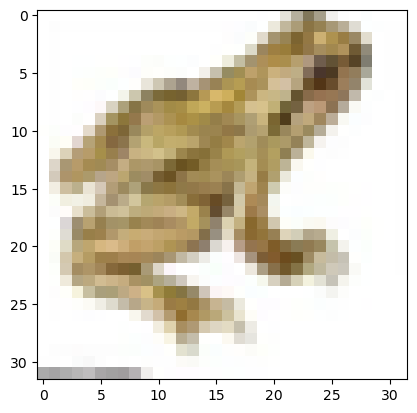

In [ ]:
# a = images[0] / 2 + 0.5          # Un-normalize
# b = a.cpu().numpy()                # Tensor -> NumPy
# c = b.transpose((1, 2, 0)) # CxHxW -> HxWxC
plt.imshow(tensor2img(images[0]))
plt.show()

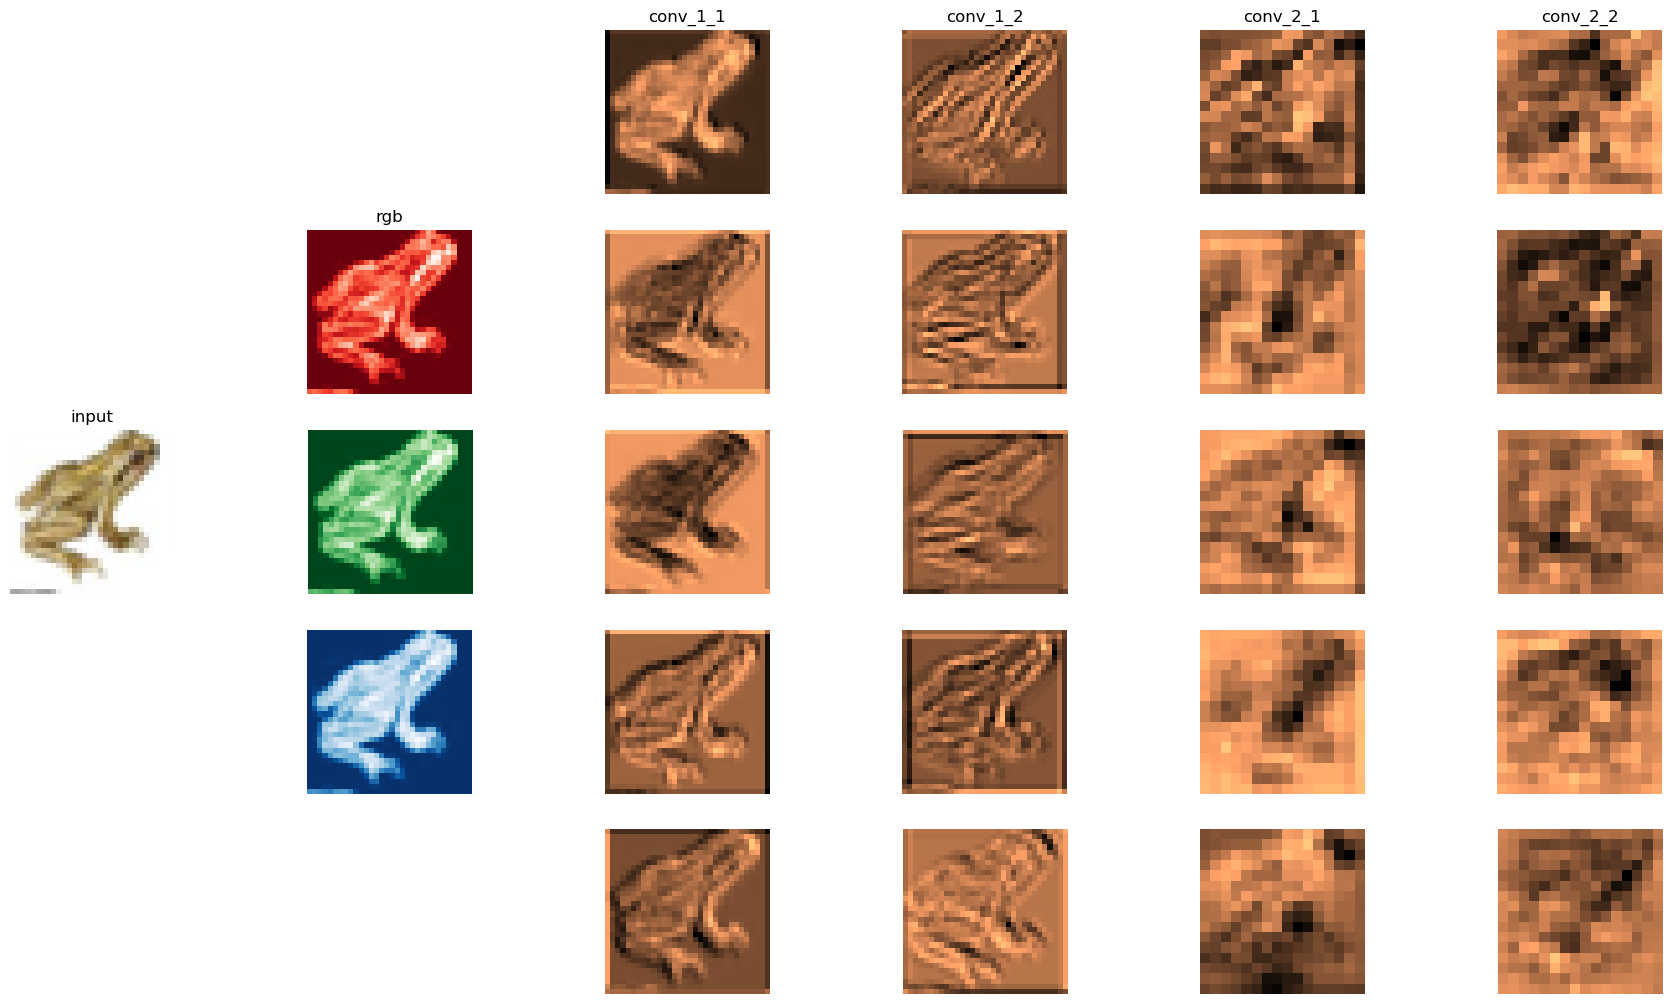

In [ ]:
import matplotlib.gridspec as gridspec
layer_names = ['input', 'rgb'] + list(activations.keys())
n_layers = len(layer_names)
max_channels = max(activations[layer].shape[1] for layer in layer_names if layer not in ('input', 'rgb'))
fig = plt.figure(figsize=(3 * n_layers, 2 * max_channels))
gs = gridspec.GridSpec(max_channels, n_layers, figure=fig)

for col, layer in enumerate(layer_names):
    if layer == 'input':
        ax = fig.add_subplot(gs[2, col])
        ax.imshow(tensor2img(images[0]), cmap='copper')
        ax.axis('off')
        ax.set_title(layer)
    elif layer == 'rgb':
        cmap_dict = {0: 'Reds', 1: 'Greens', 2: 'Blues'}
        for i in range(3):
            ax = fig.add_subplot(gs[i+1, col])
            ax.imshow(tensor2img(images[0])[:, :, i], cmap=cmap_dict[i])
            ax.axis('off')
            if i == 0:
                ax.set_title(layer)
    else:
        act = activations[layer][0]  # shape: [C, H, W]
        n_channels = act.shape[0]
        indices = torch.randperm(n_channels)[:5]
        random_samples = act[indices]
        for row, sample in enumerate(random_samples):
            ax = fig.add_subplot(gs[row, col])
            # Set title on the first row only
            if row == 0:
                ax.set_title(layer)
            ax.imshow(sample.detach().cpu(), cmap='copper')
            ax.axis('off')

    #     # Optional: Add a title to the top subplot in each column
    # fig.add_subplot(gs[0, col]).set_title(layer)
plt.tight_layout()
plt.show()

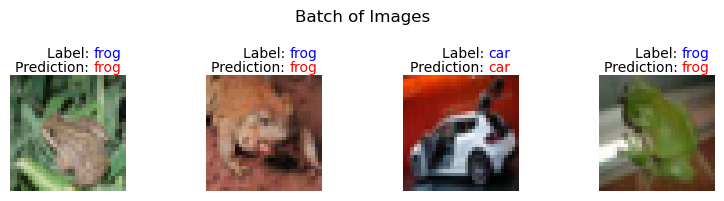

In [ ]:
images, labels = next(test_image_iterator)
images = images.to(device)
labels = labels.to(device)
output = cnn(images)
_, predicted = torch.max(output, 1)
show_images(images.to('cpu'), classes, labels.to('cpu'), predicted.to('cpu'))

In [ ]:
cnn.eval()
total = 0
correct = 0
w = set()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        _, predicted_labels = torch.max(outputs, 1)
        total += labels.shape[0]
        correct += (predicted_labels == labels).sum().item()
        w.add(predicted_label.item())
print(f'Out of {total} test images the CNN labeled {correct} correctly ({(correct / total)*100:.2f}%)')

Out of 10000 test images the CNN labeled 7464 correctly (74.64%)


In [ ]:
cnn.eval()
total = {class_name: 0 for class_name in classes}
correct = {class_name: 0 for class_name in classes}
w = set()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        _, predicted_labels = torch.max(outputs, 1)
        for actual_label, predicted_label in zip(labels, predicted_labels):
            w.add(predicted_label.item())
            if actual_label == predicted_label:
                correct[classes[predicted_label]] += 1
            total[classes[actual_label]] += 1

for class_name in sorted(classes):
    print(f'{class_name + ":":6s} {correct[class_name]:<3d} correct out of {total[class_name]:<4d} total ({(correct[class_name] / total[class_name])*100:.2f}%)')

bird:  539 correct out of 1000 total (53.90%)
car:   836 correct out of 1000 total (83.60%)
cat:   609 correct out of 1000 total (60.90%)
deer:  687 correct out of 1000 total (68.70%)
dog:   587 correct out of 1000 total (58.70%)
frog:  832 correct out of 1000 total (83.20%)
horse: 843 correct out of 1000 total (84.30%)
plane: 801 correct out of 1000 total (80.10%)
ship:  806 correct out of 1000 total (80.60%)
truck: 924 correct out of 1000 total (92.40%)
